In [1]:
%matplotlib inline
import sys
import time
import cv2
import numpy as np
from BrainDQN_mx import BrainDQN

import numpy as np
import ctypes
import win32gui
import win32api
import win32con
from PIL import ImageGrab

from matplotlib import pyplot as plt  

In [4]:
class FlappyBirdPlayer:

    def __init__(self):
        self.live_time = time.time()

    def act(self):
        win32api.keybd_event(32,0,0,0)
        win32api.keybd_event(32,0,win32con.KEYEVENTF_KEYUP,0) 

    def checkScore(self, old, new):
        reward = time.time() - self.live_time
        reward = 0.1
        terminal = np.array_equal(old, new)
        if terminal:
            self.live_time = time.time()
            reward = -1

        return reward, terminal

In [2]:
bird = cv2.imread("bird.png",0)

In [3]:
terminal = cv2.imread('8f.jpg',0)
fly = cv2.imread('x.png', 0)

In [4]:
cv2.imshow('w', fly)

In [5]:
w, h = bird.shape[::-1]

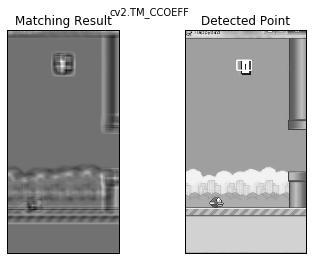

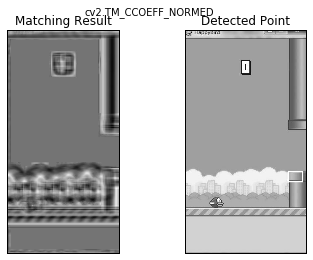

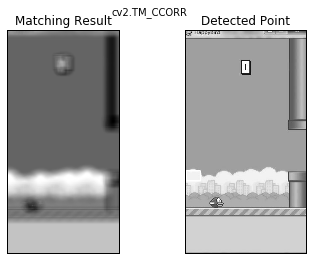

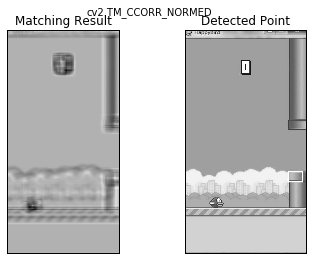

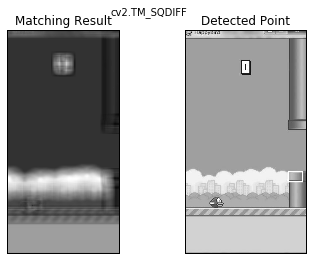

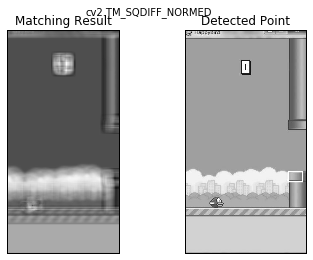

In [7]:
# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = terminal.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(terminal , bird, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)

    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

In [62]:
result = np.abs(res)**3  
val, result = cv2.threshold(result, 0.01, 0, cv2.THRESH_TOZERO)#将低于0。01的值赋值为0  
result8 = cv2.normalize(result,None,0,255,cv2.NORM_MINMAX,cv2.CV_8U)#将result转化到0-255区间  
cv2.imshow("result", result8)

In [44]:
cv2.rectangle(res,(int(x),int(y)),(int(x)+w,int(y)+h),(255,255,255),1,0) 
cv2.show('w', res)

NameError: name 'x' is not defined

In [45]:
def FindSubImage(im1, im2):
    needle = cv2.imread(im1)
    haystack = cv2.imread(im2)

    result = cv2.matchTemplate(needle,haystack,cv2.TM_CCOEFF_NORMED)
    y,x = np.unravel_index(result.argmax(), result.shape)
    return x,y

In [48]:
x, y = FindSubImage("bird.png", '8f.jpg')

In [49]:
print x, y

249 365


In [10]:

class RECT(ctypes.Structure): 
    _fields_ = [('left', ctypes.c_long), 
            ('top', ctypes.c_long), 
            ('right', ctypes.c_long), 
            ('bottom', ctypes.c_long)] 
    def __str__(self): 
        return str((self.left, self.top, self.right, self.bottom)) 


class GrabReader:

    def __init__(self, label): 
        self.label = label

        hld = win32gui.FindWindow(None, label)

        win32gui.ShowWindow(hld, win32con.SW_RESTORE)  # 强行显示界面后才好截图
        # win32gui.SetForegroundWindow(hld)  # 将窗口提到最前

        # 取当前窗口坐标  
        rect = RECT() 
        ctypes.windll.user32.GetWindowRect(hld,ctypes.byref(rect)) 
        self.hld = hld

        # 调整坐标  
        self.rangle = (rect.left+2,rect.top+2,rect.right-2,rect.bottom-2) 
        self.first = None
        self.second = np.asarray(ImageGrab.grab(self.rangle))
        self.third = np.asarray(ImageGrab.grab(self.rangle))

        self.player = FlappyBirdPlayer()

    def state(self, action):
        # 抓图
        if action[1] == 1:
            self.act()

        self.first = self.second
        self.second = self.third
        self.third = np.asarray(ImageGrab.grab(self.rangle))

        reward, terminal = self.player.checkScore(self.second, self.third)
        if terminal:
            self.act()

        return self.first, reward, terminal

    def act(self):
        self.player.act()


In [13]:
label = "FlappyBird"
t = []
# preprocess raw image to 80*80 gray image
def preprocess(observation):
    observation = cv2.cvtColor(cv2.resize(observation, (80, 80)), cv2.COLOR_BGR2GRAY)
    ret, observation = cv2.threshold(observation,1,255,cv2.THRESH_BINARY)
    return np.reshape(observation,(80,80,1))

def play():
    # Step 1: init BrainDQN
    actions = 2
    # brain = BrainDQN(actions, 'saved_networks/network-dqn_mx2200.params')
    brain = BrainDQN(actions)
    # Step 2: init Flappy Bird Game
    game = GrabReader(label)
    game.act()
    action0 = np.array([1, 0])
    ob, reward, terminal = game.state(action0)

    ob = cv2.cvtColor(cv2.resize(ob, (80, 80)), cv2.COLOR_BGR2GRAY)
    ret, ob = cv2.threshold(ob,1,255,cv2.THRESH_BINARY)
    brain.setInitState(ob)

    c = 0
    tc = 0
    
    while True:
        c += 1
        if c > 1000:
            break
        action = brain.getAction()
       #time.sleep(0.05)
        ob, rew, ter = game.state(action)
        # print action, rew, ter, c
        sys.stdout.flush()
        ob = preprocess(ob)
        if ter:
            t.append(ob)
            if len(t) > 20:
                break
        brain.setPerception(ob, action, rew, ter)
        

In [14]:
play()

time to copy
TIMESTEP 0 / STATE observe / EPSILON 0
TIMESTEP 1 / STATE observe / EPSILON 0
TIMESTEP 2 / STATE observe / EPSILON 0
TIMESTEP 3 / STATE observe / EPSILON 0
TIMESTEP 4 / STATE observe / EPSILON 0
TIMESTEP 5 / STATE observe / EPSILON 0
TIMESTEP 6 / STATE observe / EPSILON 0
TIMESTEP 7 / STATE observe / EPSILON 0
TIMESTEP 8 / STATE observe / EPSILON 0
TIMESTEP 9 / STATE observe / EPSILON 0
TIMESTEP 10 / STATE observe / EPSILON 0
TIMESTEP 11 / STATE observe / EPSILON 0
TIMESTEP 12 / STATE observe / EPSILON 0
TIMESTEP 13 / STATE observe / EPSILON 0
TIMESTEP 14 / STATE observe / EPSILON 0
TIMESTEP 15 / STATE observe / EPSILON 0
TIMESTEP 16 / STATE observe / EPSILON 0
TIMESTEP 17 / STATE observe / EPSILON 0
TIMESTEP 18 / STATE observe / EPSILON 0
TIMESTEP 19 / STATE observe / EPSILON 0
TIMESTEP 20 / STATE observe / EPSILON 0
TIMESTEP 21 / STATE observe / EPSILON 0
TIMESTEP 22 / STATE observe / EPSILON 0
TIMESTEP 23 / STATE observe / EPSILON 0
TIMESTEP 24 / STATE observe / EPSILON

In [15]:
print len(t)

21


In [20]:
np.array_equal(t[0], t[1])

True

In [19]:
from PIL import Image
im = Image.fromarray(t[0])
im.show()

TypeError: Cannot handle this data type

In [14]:
import win32gui
from PIL import ImageGrab
import win32con
import win32api
import ctypes
# from Utility.Colors import DEFAULT, RED

In [15]:
label = 'Flappy bird' #此处假设主窗口名为tt

hld = win32gui.FindWindow(None, label)

In [16]:
win32gui.ShowWindow(hld, win32con.SW_RESTORE)  # 强行显示界面后才好截图
win32gui.SetForegroundWindow(hld)  # 将窗口提到最前

error: (0, 'SetForegroundWindow', 'No error message is available')

In [17]:
class RECT(ctypes.Structure): 
    _fields_ = [('left', ctypes.c_long), 
            ('top', ctypes.c_long), 
            ('right', ctypes.c_long), 
            ('bottom', ctypes.c_long)] 
    def __str__(self): 
        return str((self.left, self.top, self.right, self.bottom)) 

rect = RECT() 

In [18]:
#取当前窗口坐标  
ctypes.windll.user32.GetWindowRect(hld,ctypes.byref(rect)) 

#调整坐标  
rangle = (rect.left+2,rect.top+2,rect.right-2,rect.bottom-2) 

#抓图  
pic = ImageGrab.grab(rangle) 

In [19]:
pic.show()

In [20]:
pic.save('test.jpg')

In [21]:
bw = pic.convert('1')
bw.show()

In [24]:
from PIL import Image
image_file = Image.open("test.jpg") # open colour image
bw = image_file.convert('1') # convert image to black and white
bw.show()